# Captcha Challenge

- Environment Requirement: Python 3.5, TensorFlow 1.2, Keras 2.0

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

### 生成字符集

In [2]:
# 获得字符集（共36种可能）
import string
characters = string.digits + string.ascii_uppercase
print(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


### 生成样本图像

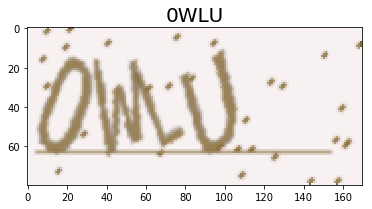

Image Shape : (80, 170, 3)


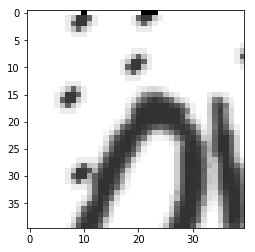

In [3]:
# 图像尺寸长与宽
width, height = 170, 80

# 所含字符个数
n_len = 4

# 所用字符集大小
n_class = len(characters)

# Captcha生成器对象
generator = ImageCaptcha(width, height)
random_str = ''.join([random.choice(characters) for i in range(n_len)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str, fontsize=20)
plt.show()

# 转为np矩阵,裁切图片
img_matrix = np.array(img)
print("Image Shape :", img_matrix.shape)
plt.imshow(img_matrix[:40, :40, 0], cmap='gray')
plt.show()

### 批量图片生成器与解码

- 具有 `yield` 关键字的函数就不再是一个普通的函数，而是一个生成器（Generator）。


- 使用时，需要：

    - 先创建该生成器的对象：`gen = generator()`
    - 然后使用 `next()` 方法调用这个对象：`next(gen)`
    - 或者使用循环语句：`for x in gen: xxx`
    
    
- 批量图片生成函数：给定要生成的图片集大小 `batch_size`，每调用一次 `next` 就生成 `batch_size` 这么多长图片。

    - 初始化返回值的时候使用np.uint8，无符号正数，取值范围[0, 255]。刚好对应图像的灰度值。
    - 使用np.uint8的另一个巨大的好处是**可以节约存储空间**，每个元素从4byte缩减到1byte的空间占用。


- 返回值

    - X 是四维np数组，[batch_size, height, width, RGB]。第一维表示图片个数。
    - Y 是长度为4的list，每个元素表示图片里的一个字符。list里面存的是二维np数组，[batch_size, n_class]。

MXML


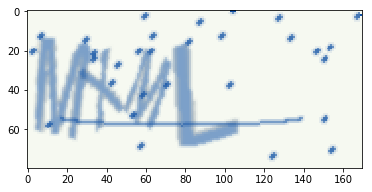

In [4]:
# X store image batches
# Y store text batches
def generate_batch(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    Y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    img_gen = ImageCaptcha(width, height)
    
    # 无限生成图片集（每次调用时都从Yield的下一句开始）
    while True:
        for pic_id in range(batch_size):
            random_str = ''.join([random.choice(characters) for i in range(n_len)])
            X[pic_id] = img_gen.generate_image(random_str) 
            for i, ch in enumerate(random_str):
                Y[i][pic_id, :] = 0                      # Reset
                Y[i][pic_id, characters.find(ch)] = 1    # Set (One-hot Encoding Label)
        yield X, Y

        
# 用于解码OLE编码的文本信息，还原成字符串
def decode(y):
    y = np.argmax(np.array(y), axis=2)
    y = y[:,0]
    return ''.join([characters[x] for x in y])


X, y = next(generate_batch(10))
plt.imshow(X[0])
print(decode(y))

### 基于VGG16创建CNN模型

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
# 别名
# Conv2D = Convolution2D
# MaxPool2D = MaxPooling2D

Using TensorFlow backend.


In [6]:
# CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> Fully-Connected X 4 -> output
def create_model(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer (由于需要识别的字符数量是4，因此需要用4个全链接子网)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]

    model = Model(inputs=input_tensor, outputs=x, name='captcha')
    return model

In [7]:
# 在每个卷积层后加了Batch Normalization Layer，可以观察到收敛速度明显增加。
def create_model_BN(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer (由于需要识别的字符数量是4，因此需要用4个全链接子网)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]

    model = Model(inputs=input_tensor, outputs=x, name='captcha')
    return model

### 开始训练模型

#### 基本流程

1. 建立模型：create
2. 转换模型：make_parallel
3. 编译模型：compile
4. 训练模型：fit_generator
5. 验证模型：predict

### 使用 fit_generator 训练

- fit 与 fit_generator 都是用来训练模型的API，区别在于：

    - `fit` 的训练数据集是现成的，训练的过程中只需要每次读进来一批就行了
    - `fit_generator` 的训练数据是实时生成的，需要提前指定好生成器，然后每一代训练的时候通过先调用生成器生产训练数据，之后再训练。

In [8]:
from helper import make_parallel
from keras.callbacks import EarlyStopping, TensorBoard, History

# 1. Create Model (4 CCM)
model = create_model_BN(3, 32)

# 2. Enable Data Parallelism
# model = make_parallel(model, 2)

# 3. Compile Model with metrics/optimizer/loss
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

#### 可以反复运行下面的Cell来累积的重复训练同一个模型

In [9]:
# the number of samples processed for each epoch is batch_size * steps_per_epochs
batch_size = 64
epoch = 1

# Training Set for one epoch
train_samples = 51200
train_steps = train_samples / batch_size

# Validation Set for one epoch
validation_sample = train_samples * 0.02
validation_steps = validation_sample / batch_size

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

# TensorBoard
# To be figured out...

# History：用来保存每一代的训练结果，以供训练结束后画图看趋势
his = History()

# Start training
model.fit_generator(generate_batch(batch_size), 
                    steps_per_epoch=train_steps, 
                    epochs=epoch, 
                    validation_data=generate_batch(128), 
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Epoch 1/1
800/800 [==============================] - 149s - loss: 6.2996 - c1_loss: 1.3385 - c2_loss: 1.5595 - c3_loss: 1.7833 - c4_loss: 1.6183 - c1_acc: 0.6924 - c2_acc: 0.6265 - c3_acc: 0.5771 - c4_acc: 0.6162 - val_loss: 2.3265 - val_c1_loss: 0.4210 - val_c2_loss: 0.5968 - val_c3_loss: 0.7652 - val_c4_loss: 0.5435 - val_c1_acc: 0.9106 - val_c2_acc: 0.8491 - val_c3_acc: 0.8213 - val_c4_acc: 0.8608


In [49]:
# 保存模型(需要安装h5py)
model.save('my_model_20epoch.h5')
model.save_weights("captcha_20epoch")

In [231]:
del model

In [8]:
# 重新载入模型
import tensorflow as tf
from keras.models import load_model
model = load_model('pretrained.h5')

### 测试模型性能

- 首先，图片生成器的真实输出（y_true）和模型的预测输出（y_pred）都是一个List，里面的元素都是二维的np.array。

- 先用argmax识别OLE编码矩阵，转换成为字符串的索引：`np.argmax(y_pred, axis=2).T`

- 再用array_equal按照每个图片进行一一比较，求平均：`np.mean(list(map(np.array_equal, y_true, y_pred)))`

In [10]:
# 20个Batch，每个Batch里面有100个图片
from tqdm import tqdm
def evaluate(model, batch_num=12, batch_size=1000):
    batch_acc = 0
    generator = generate_batch(batch_size)
    for i in tqdm(range(batch_num)):
        X, y_true = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y_true, axis=2).T
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred)))
    return batch_acc / batch_num

evaluate(model)

100%|████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.46s/it]


0.60833333333333328

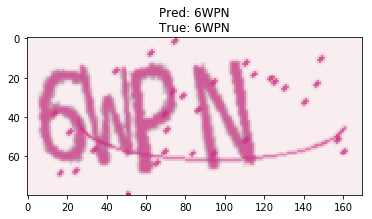

In [13]:
# 可视化对单个验证码的预测准确与否
X, y_true = next(generate_batch(1))
y_pred = model.predict(X)
pred = "Pred: " + decode(y_pred)
true = "True: " + decode(y_true)
plt.imshow(X[0])
plt.title(pred + "\n" + true)
plt.show()

### 模型可视化

1. 使用 `model.summary()` 显示模型结构

2. 使用 `pydot` 和 `Graphviz` 显示模型结构的流程图

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 80, 170, 3)    0                                            
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 78, 168, 32)   896         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 78, 168, 32)   128         conv2d_23[0][0]                  
____________________________________________________________________________________________________
conv2d_24 (Conv2D)               (None, 76, 166, 32)   9248        batch_normalization_1[0][0]      
___________________________________________________________________________________________

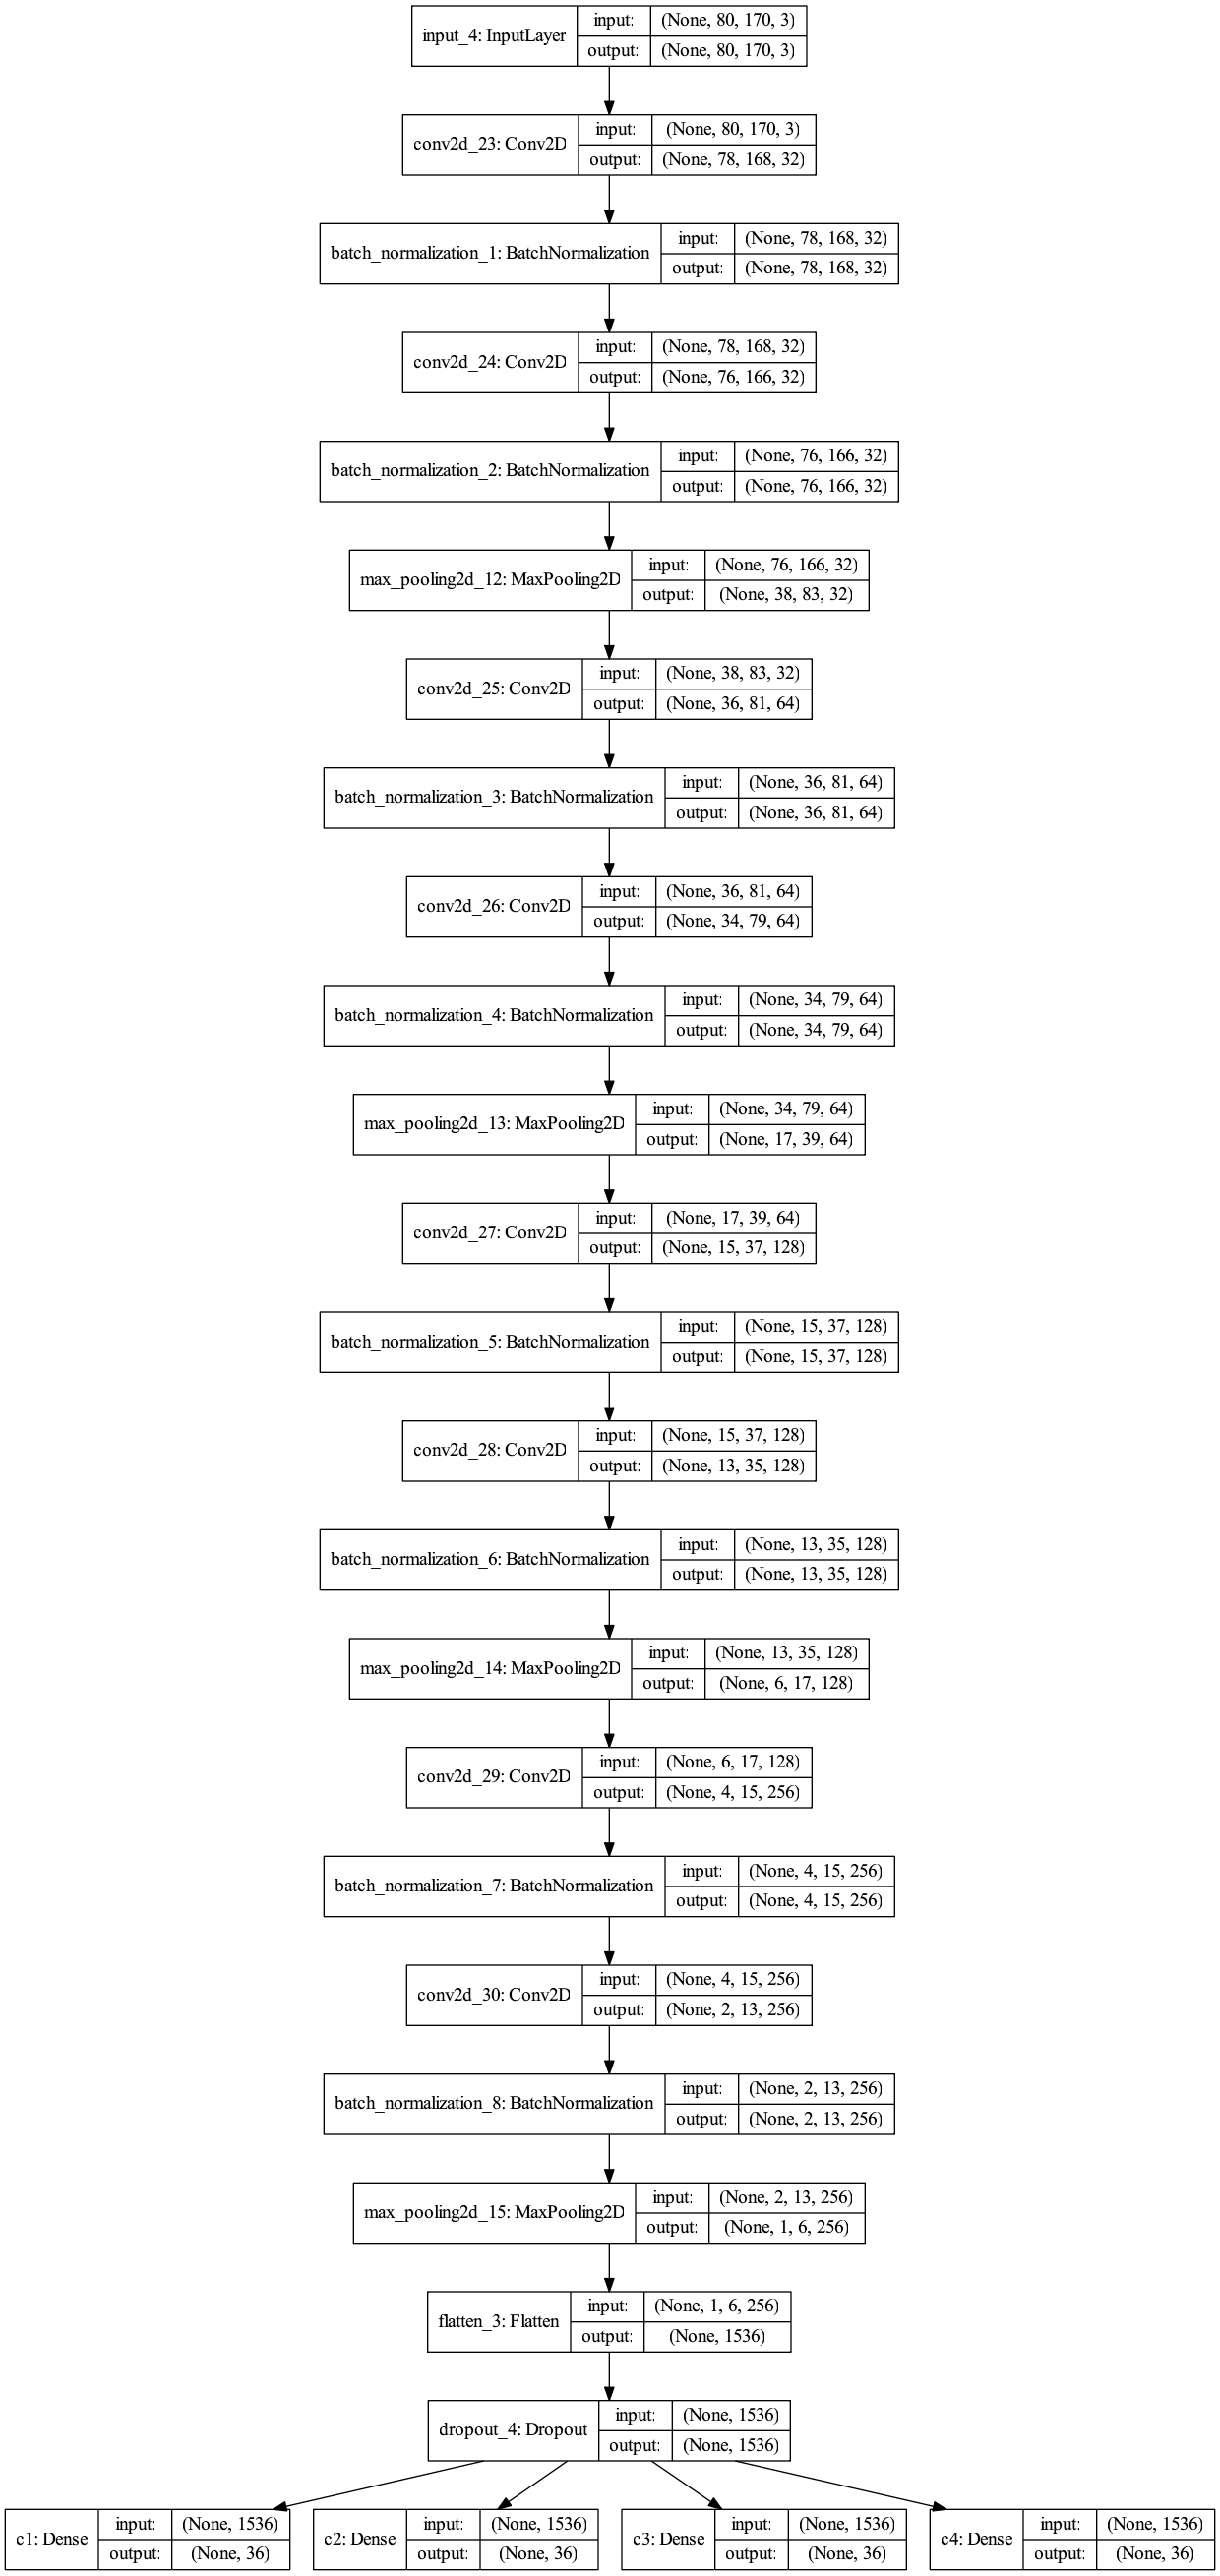

In [9]:
# 基于Pydot和Graphviz的模型可视化
# 需要添加dot.exe(Graphviz)的环境变量才能使用

from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

### CTC Loss

To be continued.

### CTC Loss Algorithm

In [11]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 定义模型

- y_pred 是模型的输出，是按顺序输出的37个字符（包括一个空白字符）的概率
- labels 是验证码，是四个数字
- input_length 表示 y_pred 的长度，我们这里是15（即允许预测结果多于原字符串长度）
- label_length 表示 labels 的长度，我们这里是4

In [98]:
from keras.models import *
from keras.layers import *
from keras.layers.merge import Concatenate, Add
rnn_size = 128

def create_model_CTC(num_CCM, num_kernel):
    input_tensor = Input((width, height, 3))
    x = input_tensor
    
    # 卷积池化层
    for i in range(num_CCM):
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = Conv2D(filters=num_kernel, kernel_size=3, strides=1, activation='relu')(x)
#         x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
        
    # 全链接层
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
    x = Dense(32, activation='relu')(x)
    
    # GRU层
    gru_1 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
    gru_1b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1_b', go_backwards=True)(x)
    gru1_merged = Add()([gru_1, gru_1b])
    
    gru_2 = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(units=rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2_b', go_backwards=True)(gru1_merged)
    x = Concatenate()([gru_2, gru_2b])
    
    # Dropout层
    x = Dropout(0.25)(x)
    
    # 全链接层输出：37类（字符集36类 + 空白符1类）
    x = Dense(n_class + 1, kernel_initializer='he_normal', activation='softmax')(x)
    base_model = Model(inputs=input_tensor, outputs=x)
    
    # CTC层，用于计算并最小化CTC Loss
    labels = Input(name='the_labels', shape=[n_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    loss_out = Lambda(function=ctc_lambda_func, output_shape=[1], name='ctc')([x, labels, input_length, label_length])
    ctc_model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
    
    return conv_shape, base_model, ctc_model

### 初始化模型

In [99]:
# 1. 创建模型
conv_shape, base_model, model = create_model_CTC(3, 32)

# 2. 编译模型
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

In [ ]:
model.summary()

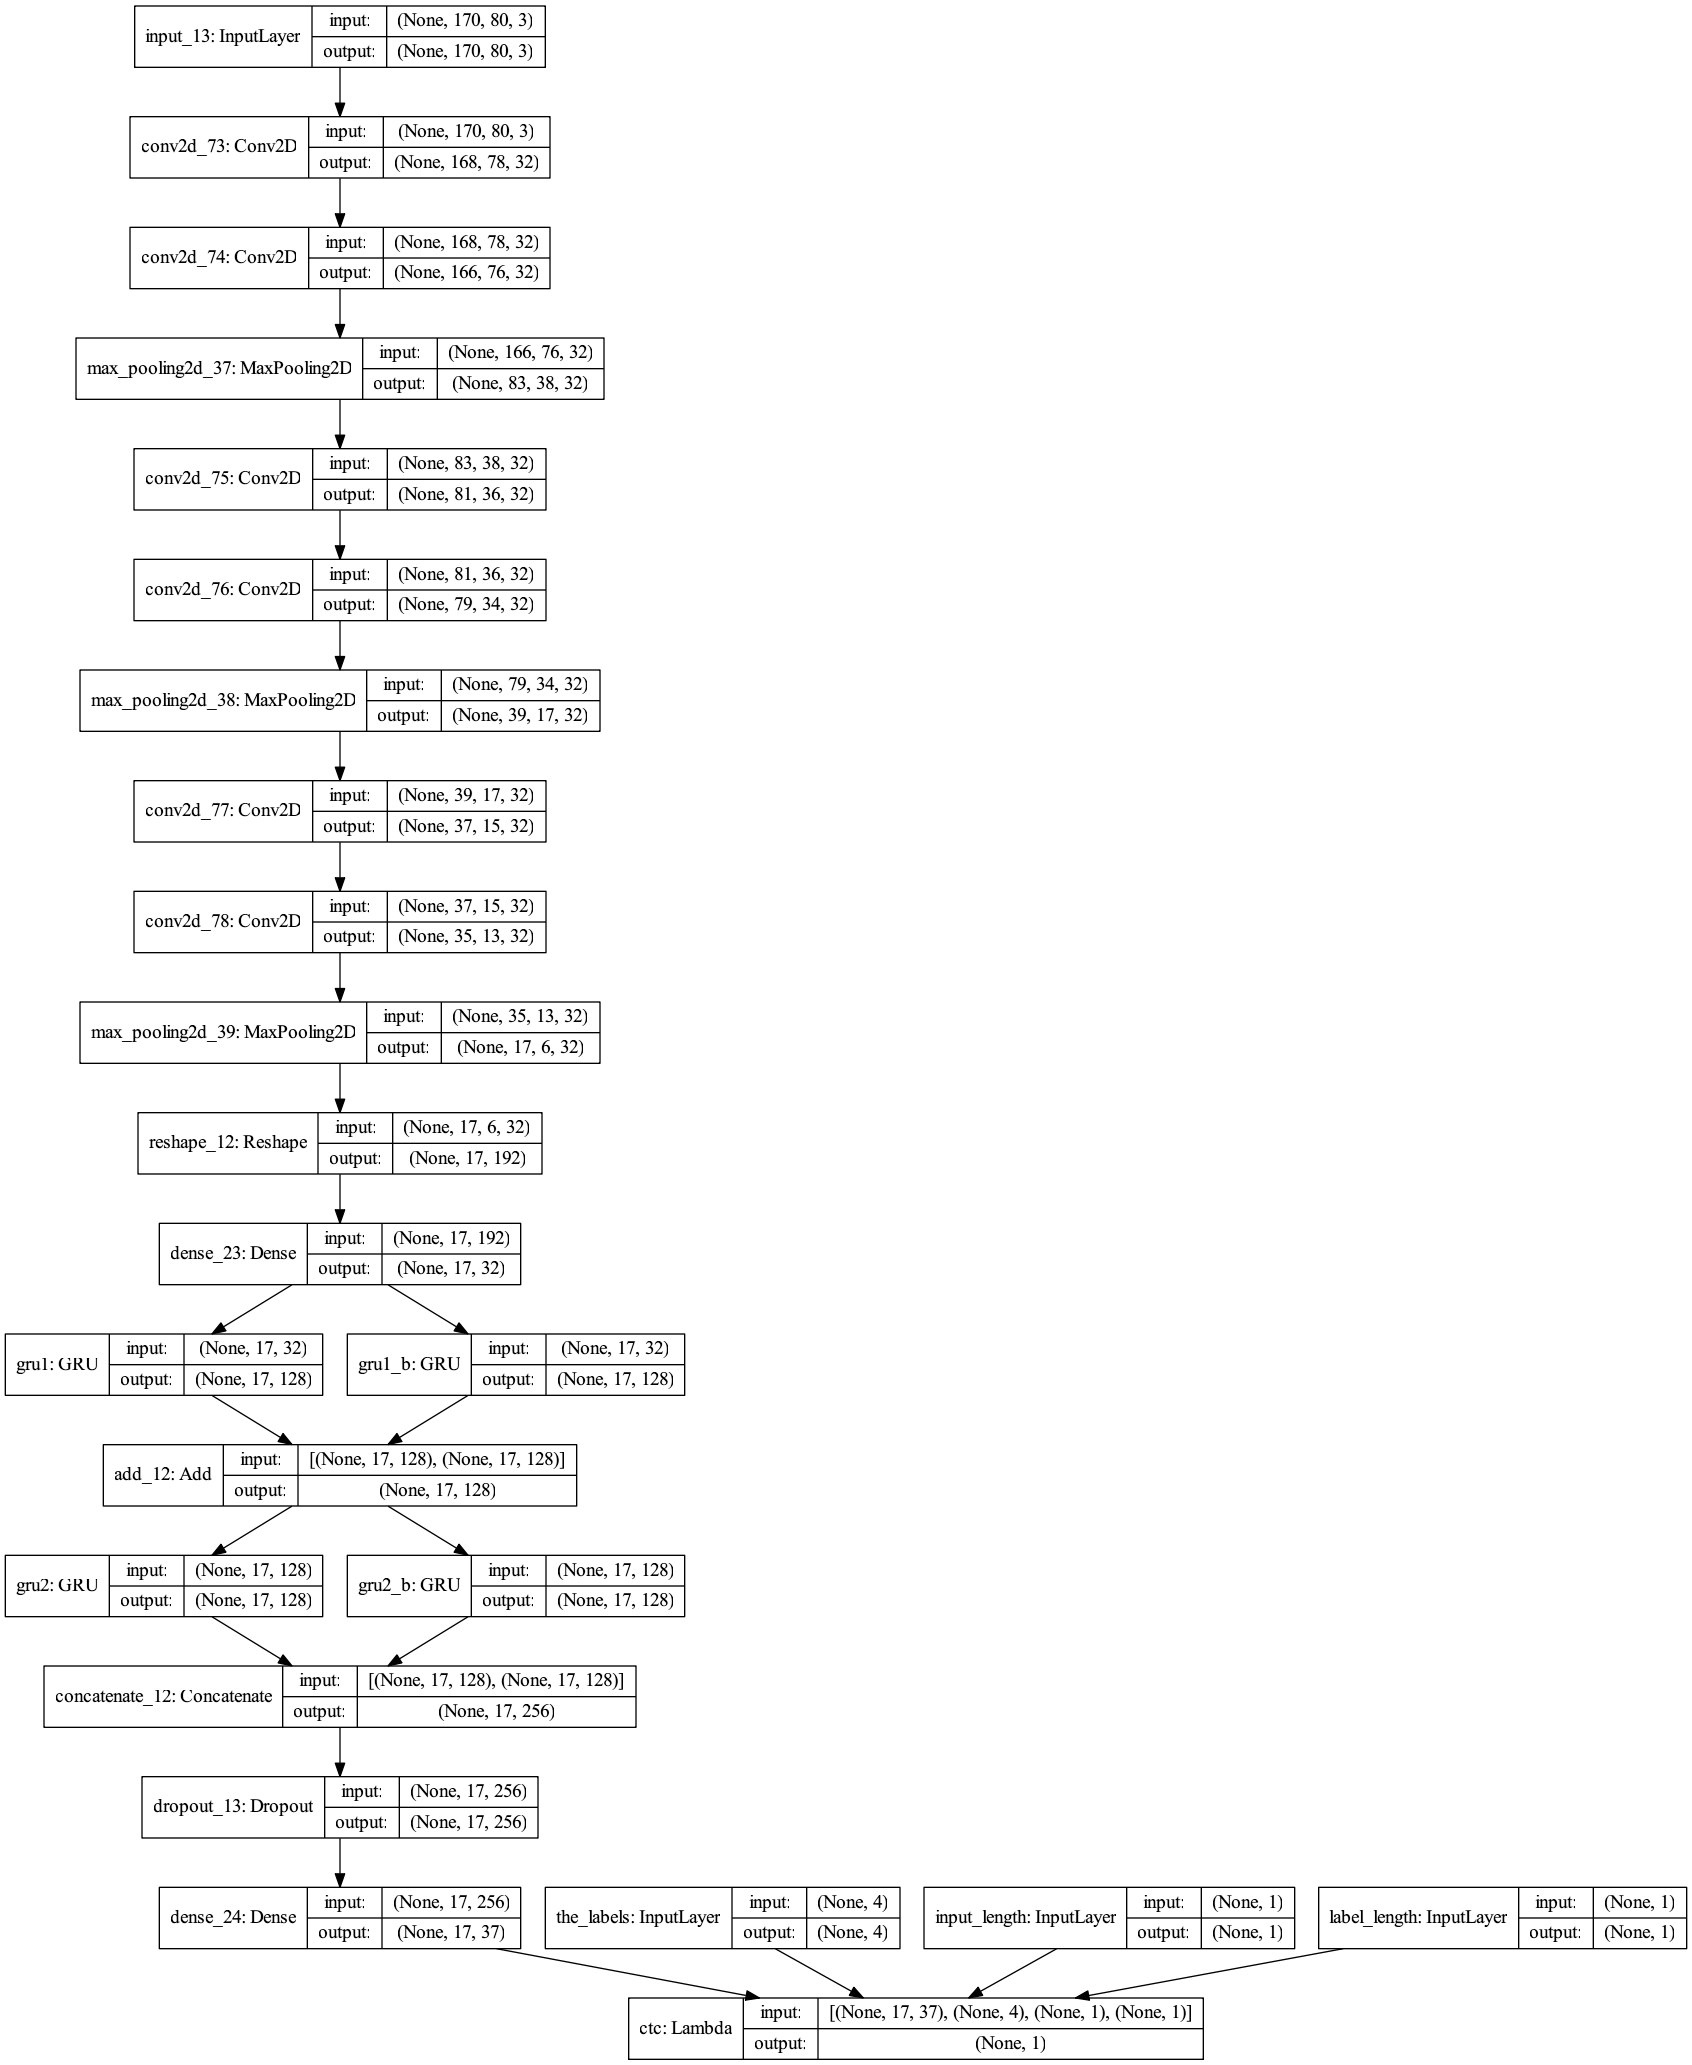

In [100]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="ctc_model.png", show_shapes=True)
Image('ctc_model.png')

### 配套的图片生成器

- `np.array.transpose(x, y, z)` 的用法：以 `transpose(1, 0, 2)` 为例

    - 被转置的np.array如果维度高于2，那么就需要指定到底交换哪两个维度的值。
    - 目前x是三维的，即[width, height, RGB] = [0, 1, 2]
    - 那么如果要交换前两个维度，就需要在transpose函数里给出新的维度排序方式，即 [1, 0, 2]
    - 可以前两个维度编号交换了，第三个维度保持不变。

In [14]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            # 图片翻转后存入X
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            # 文本存入Y
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)

### 训练模型

In [101]:
# the number of samples processed for each epoch is batch_size * steps_per_epochs
batch_size = 128
epoch = 10

# Training Set for one epoch
train_samples = 51200
train_steps = train_samples / batch_size

# Validation Set for one epoch
validation_sample = train_samples * 0.02
validation_steps = validation_sample / batch_size

# Start training
model.fit_generator(gen(128), 
                    steps_per_epoch=train_steps, 
                    epochs=epoch, 
                    validation_data=gen(128), 
                    validation_steps=validation_steps,
                    callbacks=[EarlyStopping(patience=10), evaluator])

Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 16.4408
acc: 0.000000%
400/400 [==============================] - 247s - loss: 16.4393 - val_loss: 15.8119
Epoch 2/10
399/400 [============================>.] - ETA: 0s - loss: 15.5159
acc: 0.000000%
400/400 [==============================] - 237s - loss: 15.5144 - val_loss: 14.6742
Epoch 3/10
399/400 [============================>.] - ETA: 0s - loss: 11.3962
acc: 1.875000%
400/400 [==============================] - 243s - loss: 11.3843 - val_loss: 6.5688
Epoch 4/10
399/400 [============================>.] - ETA: 0s - loss: 3.7773
acc: 62.734375%
400/400 [==============================] - 241s - loss: 3.7725 - val_loss: 1.6404
Epoch 5/10
399/400 [============================>.] - ETA: 0s - loss: 1.3907
acc: 83.359375%
400/400 [==============================] - 251s - loss: 1.3889 - val_loss: 0.7555
Epoch 6/10
399/400 [============================>.] - ETA: 0s - loss: 0.9719
acc: 87.031250%
400/400 [==================

KeyboardInterrupt: 

1 | 2 | 3 | 4 | 5 
--- | --- | --- | --- | ---
0%  | 3%  | 80% | 85% | 90%

In [102]:
# 保存模型(需要安装h5py)
model.save('captcha_ctc_8epoch_8800.h5')

In [ ]:
# 重新载入模型
from keras.models import load_model
model = load_model('captcha_ctc_80epoch_9600.h5')

### 模型性能测试

In [129]:
# 生成5个图片
[X_test, y_test, _, _], _ = next(gen(5))
for l in y_test:
    print("label: " + str(l))

# 使用CNN+GRU构成的基模型进行预测
y_pred = base_model.predict(X_test)

# 预测结果的形状
y_pred_shape = y_pred.shape
print("\ny_pred shape: [photo_id = %s, output_length = %s, n_class = %s]" % (y_pred_shape[:]), '\n')

# 预测硬解码
y_argmax = np.argmax(y_pred, axis=2)
print("Direct Decode y_pred: \n", y_argmax, '\n')

# 去掉前两个输出
shape = y_pred[:,2:,:].shape
batch_size = shape[0]
output_length = shape[1]

# 确定解码的输入长度
input_length = np.ones(batch_size) * output_length
print("CTC Input Format :", input_length, '\n')

# CTC解码：要求y_pred是tensor(samples, time_steps, num_categories)，返回值中 -1 表示空白
ctc_decode = K.ctc_decode(y_pred[:, 2:, :], input_length)
output = K.get_value(ctc_decode[0][0])
output_prob = K.get_value(ctc_decode[1])
for i in range(batch_size):
    print("label: ", output[i], "probability:", output_prob[i])

# 最后的结果只取指定长度（这里原字符串长度是4）
print(output[:, :4])

label: [29 33  5 14]
label: [ 3 24 19  1]
label: [ 3 18 30  4]
label: [13 13  1  1]
label: [11 22  6 21]

y_pred shape: [photo_id = 5, output_length = 17, n_class = 37] 

Direct Decode y_pred: 
 [[36 29 29 36 36 33 36 36 36  5 36 36 14 36 36 36 36]
 [36  3  3 36 36 24 36 36 19 19 36  1 36 36 36 36 36]
 [36 36  3 36 36 18 36 36 30 36 36 36  4 36 36 36 36]
 [36 13 13 36 36 13 36 36 36  1 36 36  1 36 36 36 36]
 [36 11 11 36 22 36 36 36 36  6 36 36 21 36 36 36 36]] 

CTC Input Format : [ 15.  15.  15.  15.  15.] 

label:  [29 33  5 14] probability: [ 0.62895101]
label:  [ 3 24 19  1] probability: [ 0.83394206]
label:  [ 3 18 30  4] probability: [ 0.21578817]
label:  [13 13  1  1] probability: [ 0.20110102]
label:  [11 22  6 21] probability: [ 0.78772956]
[[29 33  5 14]
 [ 3 24 19  1]
 [ 3 18 30  4]
 [13 13  1  1]
 [11 22  6 21]]


In [15]:
# 批量测试
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen()
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        # 使用CNN+GRU构成的基模型进行预测
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

In [105]:
evaluate(model, 3)

0.90104166666666663

In [69]:
from keras.callbacks import *
class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print(' <acc: %f%%>' % acc)
evaluator = Evaluate()

[(34, 'Y'),
 (36, ' '),
 (36, ' '),
 (19, 'J'),
 (36, ' '),
 (36, ' '),
 (16, 'G'),
 (36, ' '),
 (36, ' '),
 (31, 'V'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' ')]

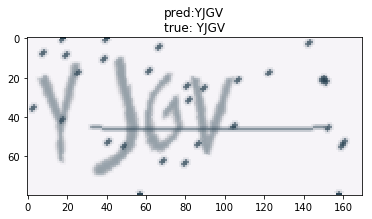

In [108]:
# 对单个图像的识别结果可视化对比
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))

# 使用基模型预测y_pred
y_pred = base_model.predict(X_test)
# 取后15个有效输出
y_pred = y_pred[:,2:,:]
# CTC解码，并且截取前4个字符
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]

# 还原为字符串
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

# 显示图像
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

# 硬解码预测输出
argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))